A brute force implementation of the multiplicative method for NMF in dask: i.e. converting all array operations to `dask.array` operations. This version does not include the regularization.

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import os
%matplotlib inline

For testing we will use the face dataset used in scikit-learn, which comes from the “Labeled Faces in the Wild” dataset, also known as LFW:

[http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz)


In [2]:
from dask.distributed import Client, progress
c = Client()
c.restart()

Client Scheduler: tcp://127.0.0.1:63725,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


In [3]:
from dask.array.image import imread
import dask.array as da
from dask import compute

In [4]:
# read the faces dataset
path = 'lfw_funneled'
faces = imread(os.path.join(path,'*','*.jpg'))
N,m,n,d = faces[:,::4,::4,:].shape


In [5]:
data = faces[:,::4,::4,0].reshape((faces.shape[0],-1))

In [6]:
X_da = c.persist(data[:100,:])

In [7]:
# compute for sklearn
X = data[:100,:].compute()

In [8]:
import time as time

In [9]:
# to avoid deviding by zero
EPSILON = np.finfo(np.float32).eps

Numpy Updates:

In [10]:
def update_H(M,H,W):
    denominator = (np.dot(W.T,np.dot(W,H)))
    denominator[np.abs(denominator) < EPSILON] = EPSILON
    H_new = H*np.dot(W.T,M)/denominator
    return(H_new)

In [11]:
def update_W(M,H,W):
    denominator = (np.dot(W,np.dot(H,H.T)))
    denominator[np.abs(denominator) < EPSILON] = EPSILON
    W_new = W*np.dot(M,H.T)/denominator
    return(W_new)

Dask Updates:

In [12]:
def update_H_da(M,H,W):
    denominator = da.dot(W.T,da.dot(W,H))
    denominator_new = da.where(da.fabs(denominator) < EPSILON,EPSILON,denominator) 
    H_new = H*da.dot(W.T,M)/denominator_new
    return(H_new)

In [13]:
def update_W_da(M,H,W):
    denominator = da.dot(W,da.dot(H,H.T))
    denominator_new = da.where(da.fabs(denominator) < EPSILON,EPSILON,denominator) 
    W_new = W*da.dot(M,H.T)/denominator_new
    return(W_new)

In [14]:
#print(update_W(M,H,W).shape)
#print(update_H(M,H,W).shape)

In [15]:
# loss
def Frobenius_loss(M,H,W):
    return(linalg(M - np.dot(W,H)))

In [16]:
# test da.where
ones = da.zeros((3,3),chunks = (3,3))
ones = da.where(ones==0,EPSILON,ones)
ones.compute()

array([[  1.19209290e-07,   1.19209290e-07,   1.19209290e-07],
       [  1.19209290e-07,   1.19209290e-07,   1.19209290e-07],
       [  1.19209290e-07,   1.19209290e-07,   1.19209290e-07]])

In [17]:
# nndsvd/a not implemented in dask yet

def initialize_da(X, k, init = 'random', W=None, H=None):
    n_components = k
    n_samples, n_features = X.shape
    if init == 'random':
        avg = da.sqrt(X.mean() / n_components)
        H = avg * da.random.RandomState(42).normal(0,1,size=(n_components, n_features),chunks=(n_components,X.chunks[1][0]))
        W = avg * da.random.RandomState(42).normal(0,1,size=(n_samples, n_components),chunks=(n_samples,n_components))
        
        H = da.fabs(H)
        W = da.fabs(W)
        return W, H
    
    if init == 'nndsvd' or init == 'nndsvda':
    # not converted to da yet

        from da.linalg import svd
    
        U, S, V = svd(X)
        W, H = np.zeros(U.shape), np.zeros(V.shape)

        # The leading singular triplet is non-negative
        # so it can be used as is for initialization.
        W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
        H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])
    
        def norm(x):
            x = x.ravel()   
            return(np.dot(x,x))

        for j in range(1, n_components):
            x, y = U[:, j], V[j, :]

            # extract positive and negative parts of column vectors
            x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
            x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

            # and their norms
            x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
            x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

            m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

            # choose update
            if m_p > m_n:
                u = x_p / x_p_nrm
                v = y_p / y_p_nrm
                sigma = m_p
            else:
                u = x_n / x_n_nrm
                v = y_n / y_n_nrm
                sigma = m_n

            lbd = np.sqrt(S[j] * sigma)
            W[:, j] = lbd * u
            H[j, :] = lbd * v

        eps=1e-6

        if init == 'nndsvd':
            W[W < eps] = 0
            H[H < eps] = 0
    
        if init == 'nndsvda':
            avg = X.mean()
            W[W == 0] = avg
            H[H == 0] = avg
    
        return W, H
    
        

In [18]:
# random/NNDSVD/A initialization from sklearn
def initialize(X, k, init, W=None, H=None):
    
    n_components = k
    n_samples, n_features = X.shape
    
    if init == 'random':
        avg = np.sqrt(X.mean() / n_components)
        H = avg * np.random.RandomState(42).normal(0,1,size=(n_components, n_features))
        W = avg * np.random.RandomState(42).normal(0,1,size=(n_samples, n_components))
        
        np.fabs(H, H)
        np.fabs(W, W)
        return W, H
    
    if init == 'nndsvd' or init == 'nndsvda':

        from scipy.linalg import svd
    
        U, S, V = svd(X, full_matrices = False)
        W, H = np.zeros(U.shape), np.zeros(V.shape)

        # The leading singular triplet is non-negative
        # so it can be used as is for initialization.
        W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
        H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])
    
        def norm(x):
            x = x.ravel()   
            return(np.dot(x,x))

        for j in range(1, n_components):
            x, y = U[:, j], V[j, :]

            # extract positive and negative parts of column vectors
            x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
            x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

            # and their norms
            x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
            x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

            m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

            # choose update
            if m_p > m_n:
                u = x_p / x_p_nrm
                v = y_p / y_p_nrm
                sigma = m_p
            else:
                u = x_n / x_n_nrm
                v = y_n / y_n_nrm
                sigma = m_n

            lbd = np.sqrt(S[j] * sigma)
            W[:, j] = lbd * u
            H[j, :] = lbd * v

        eps=1e-6

        if init == 'nndsvd':
            W[W < eps] = 0
            H[H < eps] = 0
    
        if init == 'nndsvda':
            avg = X.mean()
            W[W == 0] = avg
            H[H == 0] = avg
            
    if 'init' == 'custom':
        if np.min(H) < 0 or np.min(W) < 0:
            raise ValueError('H and W should be nonnegative')
            
    
    return(W,H)


In [19]:
k = 100

In [20]:
W_init, H_init = initialize_da(X_da,k,init='random')

In [21]:
W_init = W_init.compute()
H_init = H_init.compute()

In [22]:
# fitting function
EPSILON = np.finfo(np.float32).eps
def fit(M, k, nofit, init, W=None, H=None):
    
    W, H = initialize(M, k, init, W, H)
    

    
    err = []
    for it in range(nofit):
        W = update_W(M,H,W)
        #print(np.sum(np.isnan(W)))
        H = update_H(M,H,W)
        err.append(linalg.norm(M - np.dot(W,H)))
        print('Iteration '+str(it)+': error = '+ str(err[it]))
    return(W, H, err)

In [23]:
# fitting function
def fit_da(M, k, nofit, init='random', W=None, H=None):
    
    from dask import compute
    
    # initialize H and W
    #u,s,vt = da.linalg.svd(M)
    #uk,sk,vtk = compute(u[:,k],s[:k],vt[:k])
    #W = uk
    #H = da.dot(np.diag(sk),vtk[:k,:])
    
    W, H = initialize_da(M, k, init, W, H)
    
    err = []
    for it in range(nofit):
        W = update_W_da(M,H,W)
        H = update_H_da(M,H,W)
        
        err.append(da.linalg.norm(M - da.dot(W,H)))  
        
    return(W,H,err)

In [24]:
X_da = X_da.rechunk((100,441))
X_da

dask.array<rechunk-merge, shape=(100, 3969), dtype=uint8, chunksize=(100, 441)>

In [25]:
nofit = 1

#### numpy

In [66]:
W, H, err = fit(X, k, 100, init = 'custom', W=W_init, H=H_init)

Iteration 0: error = 40219.3314225
Iteration 1: error = 39918.6699087
Iteration 2: error = 39658.7028492
Iteration 3: error = 39357.2856421
Iteration 4: error = 38990.0221189
Iteration 5: error = 38528.9408685
Iteration 6: error = 37945.6984237
Iteration 7: error = 37220.0283742
Iteration 8: error = 36352.9102935
Iteration 9: error = 35377.3695409
Iteration 10: error = 34354.3360701
Iteration 11: error = 33349.5755042
Iteration 12: error = 32407.8066191
Iteration 13: error = 31543.8792463
Iteration 14: error = 30751.6653625
Iteration 15: error = 30017.4311052
Iteration 16: error = 29328.3436579
Iteration 17: error = 28675.3620089
Iteration 18: error = 28053.1920051
Iteration 19: error = 27459.3183843
Iteration 20: error = 26892.9182316
Iteration 21: error = 26353.9271611
Iteration 22: error = 25842.3673951
Iteration 23: error = 25357.9691667
Iteration 24: error = 24900.0504531
Iteration 25: error = 24467.5607672
Iteration 26: error = 24059.1816623
Iteration 27: error = 23673.4254734
It

In [67]:
#W

In [68]:
#H

In [69]:
#### plt.plot(err)

In [70]:
data_fitted = np.dot(W,H).reshape(-1,m,n)

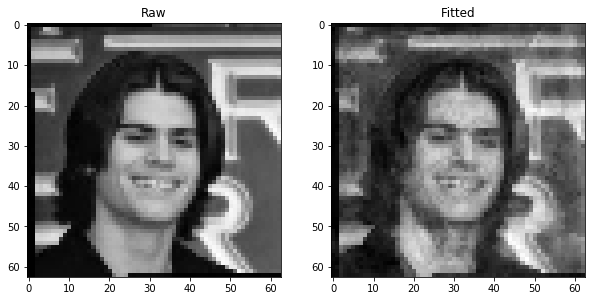

In [71]:
# plot the results
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(faces[1,::4,::4,0],cmap = 'gray')
plt.title('Raw')
    
plt.subplot(1,2,2)
plt.imshow(data_fitted[1,:,:],cmap = 'gray')
plt.title('Fitted')

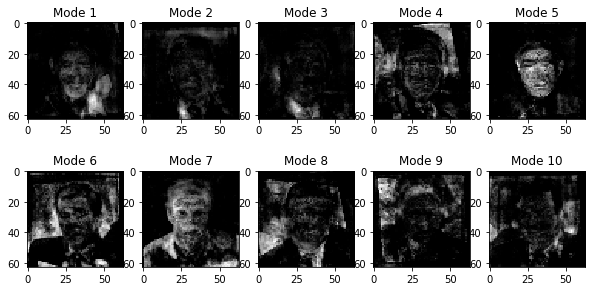

In [72]:
# plot the results
u = H.reshape((-1,m,n))
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow(u[i,:,:],cmap = 'gray')
    plt.title('Mode '+str(i+1))

#### scikit-learn

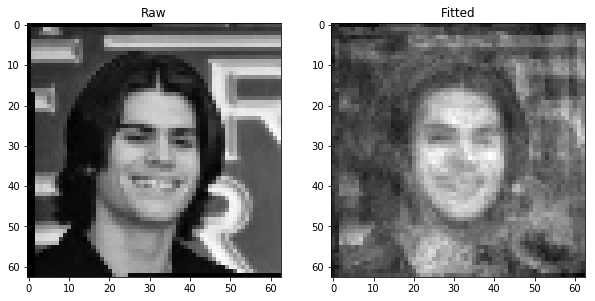

In [73]:
# compare to sklearn multiplicative method 
# only latest versions have the multiplicative method
# performance seems worse than the coordinate descent method
 
from sklearn.decomposition import NMF
nmf = NMF(n_components = k,init = 'nndsvda',solver = 'mu',max_iter = 100)
W = nmf.fit_transform(X)
H = nmf.components_
data_fitted_sk = np.dot(W,H)

#plot the results
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(faces[1,::4,::4,0],cmap = 'gray')
plt.title('Raw')
    
plt.subplot(1,2,2)
plt.imshow(data_fitted_sk.reshape(-1,m,n)[1,:,:],cmap = 'gray')
plt.title('Fitted')

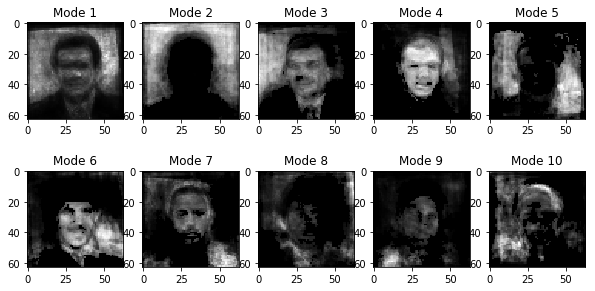

In [74]:
# plot the results
u = H.reshape((-1,m,n))
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow(u[i,:,:],cmap = 'gray')
    plt.title('Mode '+str(i+1))

#### da.array

In [75]:
W, H, err = fit_da(X_da,k,100, init = 'random')

In [76]:
W, H, err = compute(W,H,err)

In [77]:
data_fitted = np.dot(W,H).reshape(-1,m,n)

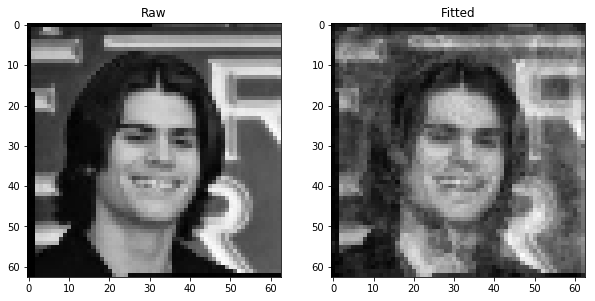

In [78]:

#plot the results
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.imshow(faces[1,::4,::4,0],cmap = 'gray')
plt.title('Raw')
    
plt.subplot(1,2,2)
plt.imshow(data_fitted.reshape(-1,m,n)[1,:,:],cmap = 'gray')
plt.title('Fitted')

In [79]:
#H.compute()
#W.compute()

CPU times: user 415 ms, sys: 23.6 ms, total: 438 ms
Wall time: 423 ms


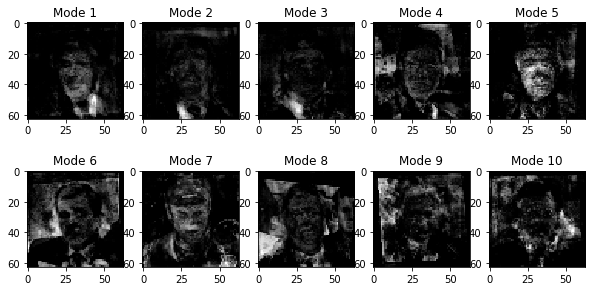

In [80]:
%%time
# plot the results
u = H.reshape((-1,m,n))
plt.figure(figsize = (10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow(u[i,:,:],cmap = 'gray')
    plt.title('Mode '+str(i+1))

In [45]:
from numpy.random import seed, uniform

In [47]:
uniform()

0.5989977136290761

In [48]:
np.random.RandomState(1969).uniform()

0.5989977136290761

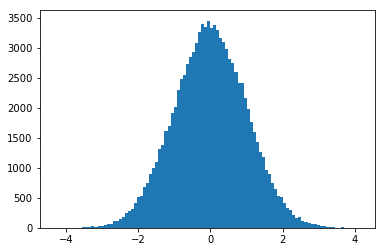

In [49]:
import matplotlib.pyplot as plt
fig = plt.hist((da.random.RandomState(1969).normal(0,1,size = 100000,chunks=(100000,)).compute()),bins=100)

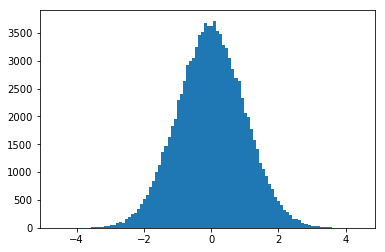

In [50]:
fig = plt.hist((np.random.RandomState(1969).normal(0,1,size = 100000)),bins = 100)